# NLP: Text Classification of Comments

### Introduction-

The dataset is a collection of roughly 2 million comments posted publicly in an online forum. These comments were rated by humans and assigned a continuous score between 0 and 1 representing overall "toxicity" of each comment. These scores were broken down by `['toxicity'] >= .5` into the categories "toxic" and "nontoxic". 

The binary classification of toxicity is our dependent variable for this exercise. 

### Data Processing-

In [57]:
# Import the required libraries
import os
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import gc
tqdm.pandas()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import TruncatedSVD
%matplotlib inline

In [2]:
# Set the working directory
wd = '/Users/zxs/Documents/code/kaggle/sentiment/'
os.chdir(wd)

In [3]:
# Load the data
train_df = pd.read_csv('train.csv.zip', compression = 'zip')
test_df = pd.read_csv('test.csv.zip', compression = 'zip')

# Create a smaller sample size for demonstration purposes
train = train_df.sample(n = 10000, random_state = 100, replace = False)
test = train_df.sample(n = 1000, random_state = 100, replace = False)

In [4]:
# Create a smaller sample size for demonstration purposes
train = train_df.sample(n = 10000, random_state = 100, replace = False)
test = train_df.sample(n = 1000, random_state = 100, replace = False)

# Assign labels based on toxicity
train['toxicity'] = train['target'].progress_apply(lambda x: 'positive' if x >= .5 else 'negative')
test['toxicity'] = test['target'].progress_apply(lambda x: 'positive' if x >= .5 else 'negative')

100%|██████████| 1000/1000 [00:00<00:00, 327628.81it/s]


### Text Processing:
        
        - lower case
        - remove punctuation
        - tokenize
        - remove stop words
        - stem the remaining words
        - extract features

In [5]:
# Filter stopwords
stop_words = set(stopwords.words('english'))

# Stem the words
ps = PorterStemmer()

In [6]:
# Separate the text for processing
train_text = train['comment_text']
test_text = test['comment_text']

train_y = train['toxicity']
test_y = test['toxicity']

#### Training Data-

In [7]:
# Remove punctuation
train_text1 = train_text.progress_apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Convert to lower case
train_text2 = train_text1.progress_apply(lambda x: x.lower())
    
# Tokenize the words
train_text3 = train_text2.progress_apply(lambda x: word_tokenize(x))

# Filter stopwords
stop_words = set(stopwords.words('english'))

# Remove stop words
train_text4 = train_text3.progress_apply(lambda x: [i for i in x if i not in stop_words])
    
# Stem the words
ps = PorterStemmer()

train_text5 = train_text4.progress_apply(lambda x: [ps.stem(y) for y in x])
    
# Rejoin the stemmed content
train_text6 = train_text5.progress_apply(lambda x: ' '.join(x))

100%|██████████| 10000/10000 [00:00<00:00, 344793.05it/s]


#### Test Data-

In [8]:
# Remove punctuation
test_text1 = test_text.progress_apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Convert to lower case
test_text2 = test_text1.progress_apply(lambda x: x.lower())
    
# Tokenize the words
test_text3 = test_text2.progress_apply(lambda x: word_tokenize(x))

# Filter stopwords
stop_words = set(stopwords.words('english'))

# Remove stop words
test_text4 = test_text3.progress_apply(lambda x: [i for i in x if i not in stop_words])
    
# Stem the words
ps = PorterStemmer()

test_text5 = test_text4.progress_apply(lambda x: [ps.stem(y) for y in x])
    
# Rejoin the stemmed content
test_text6 = test_text5.progress_apply(lambda x: ' '.join(x))

# Combine text w/ labels
train1 = pd.concat([train_text6, train['toxicity']], axis = 1)
test1 = pd.concat([test_text6, test['toxicity']], axis = 1)

100%|██████████| 1000/1000 [00:00<00:00, 304508.78it/s]


### Modeling:

We will run two different models in this exercise.

1) *Naive Bayes Classifier* - comparing frequency of words in training data to the probabilities of word presence in training material.

2) *Random Forest Classifier* - for visualization of word features and their effects on likelihood of predicted outcome.

In [9]:
# Functions to process features
def word_fts(words):
    
    return dict([(word, True) for word in words])

def process_fts(df):
    
    # Process data
    data = df.values.tolist()
    
    # Iterate the tokenized data to extract features
    toxic = []
    nontoxic = []

    for i in data:
    
        if i[1] == 'positive':
        
            toxic.append(word for word in word_tokenize(i[0]))

        else:
        
            nontoxic.append(word for word in word_tokenize(i[0]))
            
    # Remove duplicates        
    toxic = set(toxic)
    nontoxic = set(nontoxic) 

    # ID features
    toxicft = [(word_fts(tox), 'positive') for tox in toxic]
    nontoxicft = [(word_fts(nontox), 'negative') for nontox in nontoxic]

    # Recombine features
    out = toxicft + nontoxicft   

    return out

#### Naive Bayes Classifier - 

In [10]:
# Apply functions to data
train2 = process_fts(train1) 
test2 = process_fts(test1) 

print('Features have been processed...')

Features have been processed...


In [11]:
'''
    Model
'''

nbc = NaiveBayesClassifier.train(train2)

# Evaluate
print ('Accuracy of the Naive Bayes model on the toxicity data is:', nltk.classify.util.accuracy(nbc, test2))
nbc.show_most_informative_features() 

Accuracy of the Naive Bayes model on the toxicity data is: 0.816
Most Informative Features
                   idiot = True           positi : negati =     70.0 : 1.0
                  stupid = True           positi : negati =     56.7 : 1.0
                    scum = True           positi : negati =     55.6 : 1.0
                   moron = True           positi : negati =     35.8 : 1.0
                 scumbag = True           positi : negati =     33.4 : 1.0
                 insecur = True           positi : negati =     33.4 : 1.0
                   clown = True           positi : negati =     33.4 : 1.0
                    ploy = True           positi : negati =     26.0 : 1.0
                   pussi = True           positi : negati =     26.0 : 1.0
                  malign = True           positi : negati =     26.0 : 1.0


*Low accuracy obtained as a result of smaller size of training set*

#### Random Forest Model -

Modeling a random forest on text data requires a different procedure than the Naive Bayes Classifier. 

In order to create a random forest model, we will need to create TF-IDF vectors for all of the comments.

In [12]:
# Initialize TF-IDF model
tf_idf = TfidfVectorizer(analyzer = 'word', token_pattern = r'\w{1,}', max_features = 5000)

In [13]:
# Create the data
x_tf_idf = tf_idf.fit_transform([i for i in train_text6])

x_tf_idf = pd.DataFrame(x_tf_idf.toarray(), columns = tf_idf.get_feature_names())

test_x_tf_idf = tf_idf.fit_transform([i for i in test_text6])

test_x_tf_idf = pd.DataFrame(test_x_tf_idf.toarray(), columns = tf_idf.get_feature_names())

In [61]:
# Map the labels
y = train['toxicity'].map({'negative': 0,
                           'positive': 1})

test_y = test['toxicity'].map({'negative': 0,
                               'positive': 1})

In [62]:
# Initialize the Random Forest
rfc = RandomForestClassifier(random_state = 100)

rfc.fit(x_tf_idf, y)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

In [68]:
# Predict
preds = rfc.predict(test_x_tf_idf)

In [69]:
# Evaluate
print('The accuracy of the Random Forest model on the toxicity data is: {}'.format(accuracy_score(test_y, preds)))

The accuracy of the Random Forest model on the toxicity data is: 0.888


Interestingly enough, our Random Forest model performs better on the small sample set than the Naive Bayes model. Now, lets produce some visuals to help explain the results. Lets take a look at the AUC of the ROC curve as well.

In [67]:
fpr, tpr, thresholds = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

print(roc_auc)

0.506102928617414


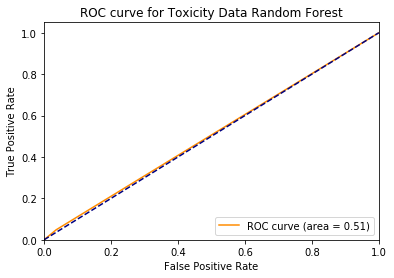

In [66]:
plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', label = 'ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color = 'navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Toxicity Data Random Forest')
plt.legend(loc = "lower right")
plt.show()

### Visualizing:

Now that we have obtained our results, we should visualize the data. This can be done using "latent semantic analysis." In addition to this, we can also perform an LDA or "Latent Dirichlet Allocation" in order to model the topics present in the individual comments. 

Lets proceed...

#### Latent Semantic Analysis-

In order to perform an LSA, we must first model the data using an SVD model, which stands for **Singular Value Decomposition**.

In [19]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components = 20, algorithm = 'randomized', n_iter = 100, random_state = 100)

svd_model.fit(x_tf_idf)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=100,
       random_state=100, tol=0.0)

In [22]:
# Examine components
terms = tf_idf.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    
    print("Topic ", str(i), ": ")
    
    print([t[0] for t in sorted_terms])

Topic  0 : 
['randominnoc', 'us', 'miner', 'explan', 'wynn', 'press', 'day']
Topic  1 : 
['us', 'restrict', 'throttl', 'wella', 'dataand', 'potash', 'casket']
Topic  2 : 
['total', 'quotat', 'team', 'fathom', 'us', 'pee', 'immigr']
Topic  3 : 
['explan', 'day', 'miner', 'randominnoc', 'factual', 'us', 'quotat']
Topic  4 : 
['miner', 'fals', 'trickl', 'randominnoc', 'challeng', 'total', 'fight']
Topic  5 : 
['fals', 'explan', 'trickl', 'factual', 'wikipedia', 'conklin', 'wrist']
Topic  6 : 
['miner', 'explan', 'press', 'wella', 'yield', 'mouth', 'surgeri']
Topic  7 : 
['wella', 'randominnoc', 'fals', 'trickl', 'core', 'serveremail', 'purchas']
Topic  8 : 
['day', 'trickl', 'total', 'challeng', 'wella', 'miner', 'press']
Topic  9 : 
['press', 'randominnoc', 'us', 'fals', 'total', 'day', 'ahead']
Topic  10 : 
['fals', 'wella', 'shower', 'wynn', 'serveremail', 'purchas', 'core']
Topic  11 : 
['factual', 'wella', 'randominnoc', 'trickl', 'miner', 'press', 'yield']
Topic  12 : 
['wikipedia',

Now that we have a list of topics and keywords, we can visualize the data as well in a 2D-space.

In [26]:
# Visualize topic modeling
x_topics = svd_model.fit_transform(x_tf_idf)
embedding = umap.UMAP(n_neighbors = 150, min_dist = 0.5, random_state = 100).fit_transform(x_topics)

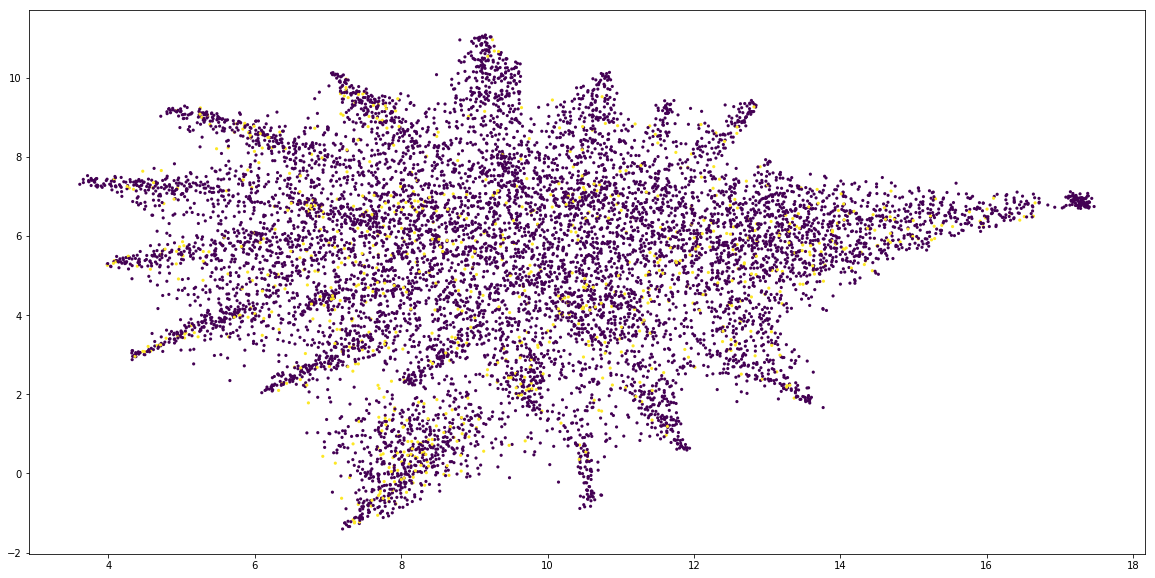

In [70]:
plt.figure(figsize = (20, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c = y, s = 10, edgecolor = 'none')
plt.show()